In [361]:
import numpy as np
import enum
import cv2
from ipywidgets import interact, fixed, IntRangeSlider, Layout

import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects, remove_small_holes

In [362]:
class ColorScheme(enum.Enum):
    BGR = 1


class ProbioDetector:
    @staticmethod
    def detect(img: np.ndarray, img_color_scheme: ColorScheme):
        pass

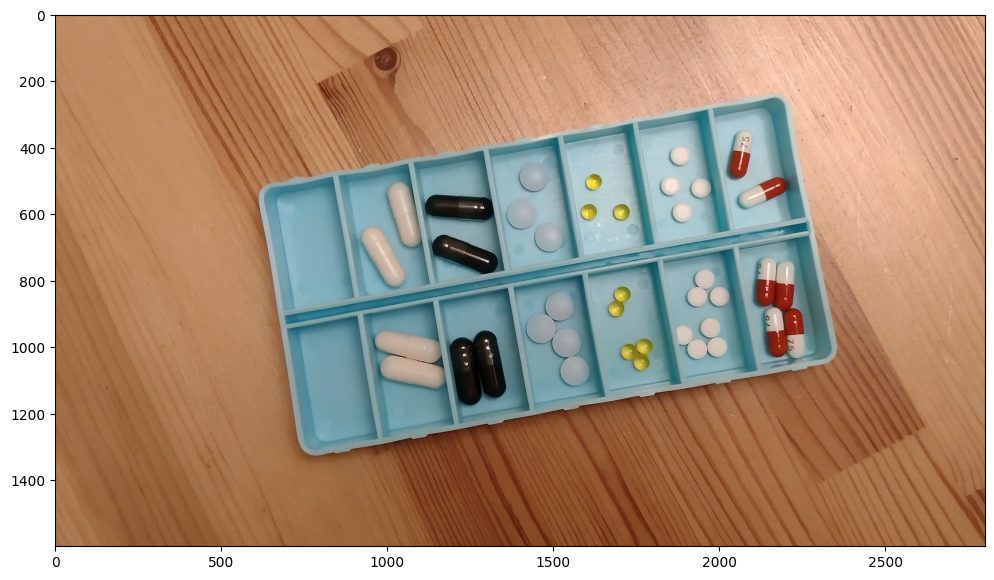

In [363]:
calib = cv2.imread("calib.png")
calib_color_scheme = ColorScheme.BGR
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(cv2.cvtColor(calib, cv2.COLOR_BGR2RGB))

In [364]:
calib_rgb = cv2.cvtColor(calib, cv2.COLOR_BGR2RGB)

calib_eq_hist = calib_rgb

In [365]:
def remove_large_objects(img, max_size):
    return img & ~remove_small_objects(img, min_size=max_size)

In [366]:
thresholded_img_pillbox = None


@interact(
    img=fixed(calib_eq_hist),
    h=IntRangeSlider(
        min=0, max=180, step=1, value=[40, 180], layout=Layout(width="500px")
    ),
    s=IntRangeSlider(
        min=0, max=255, step=1, value=[0, 255], layout=Layout(width="500px")
    ),
    v=IntRangeSlider(
        min=0, max=255, step=1, value=[0, 255], layout=Layout(width="500px")
    ),
)
def get_in_range(img, h, s, v):
    global thresholded_img_pillbox
    min_h, max_h = h
    min_s, max_s = s
    min_v, max_v = v

    thresholded = cv2.inRange(
        cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
        (min_h, min_s, min_v),
        (max_h, max_s, max_v),
    )

    plt.subplots(1, 1, figsize=(12, 8))[1].imshow(~thresholded, cmap="gray")
    thresholded_img_pillbox = ~thresholded

interactive(children=(IntRangeSlider(value=(40, 180), description='h', layout=Layout(width='500px'), max=180),…

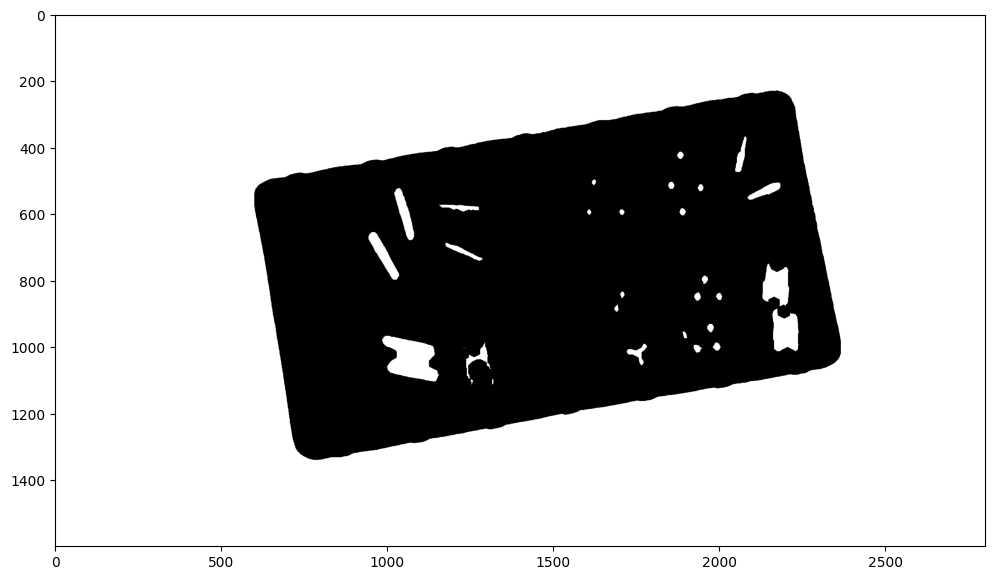

In [367]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
eroded = cv2.erode(thresholded_img_pillbox, kernel, iterations=8)

plt.subplots(1, 1, figsize=(12, 8))[1].imshow(eroded, cmap="gray")

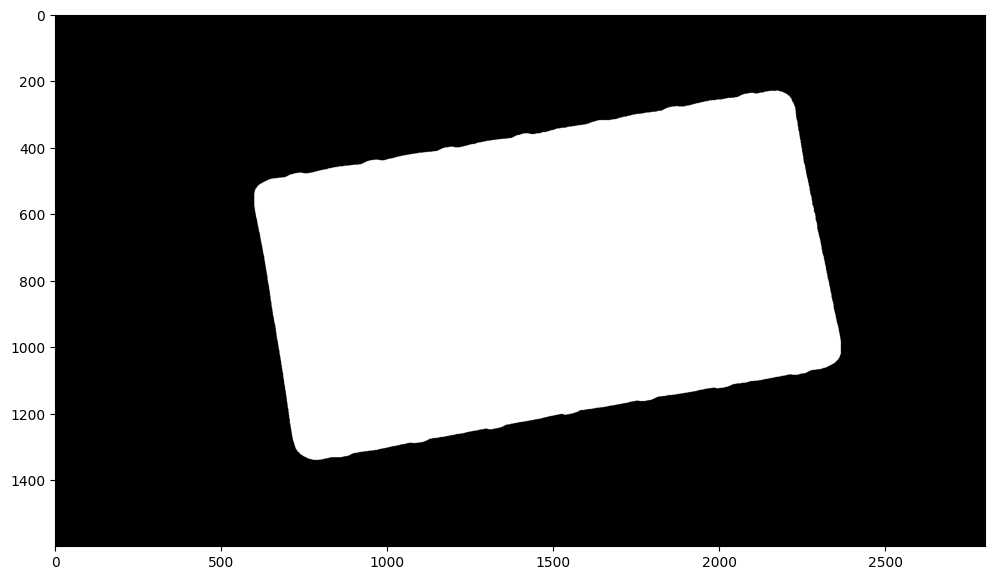

In [368]:
full_pillbox = remove_small_holes((~eroded) > 0, area_threshold=20000)
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(full_pillbox, cmap="gray")

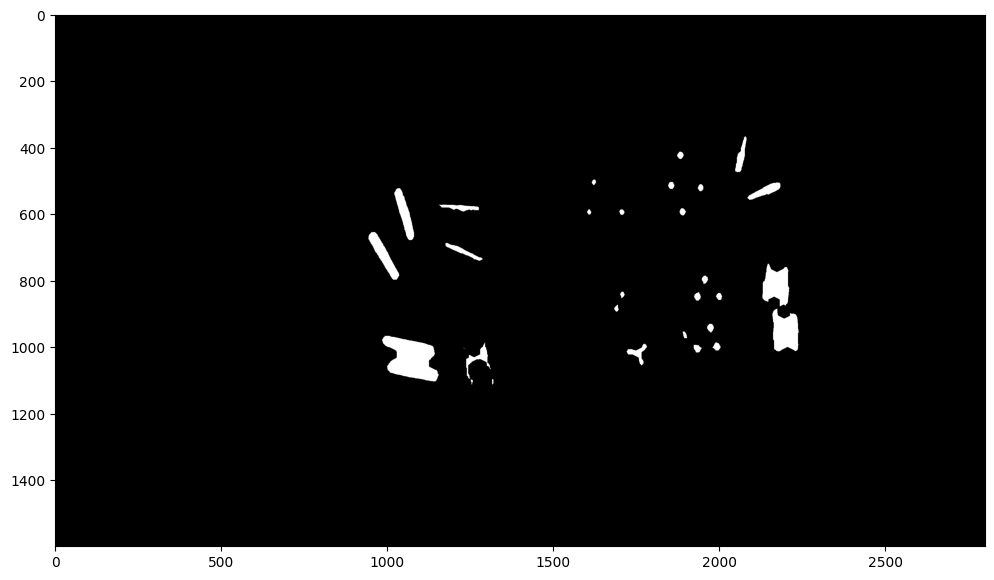

In [369]:
pills = eroded & full_pillbox
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(pills, cmap="gray")

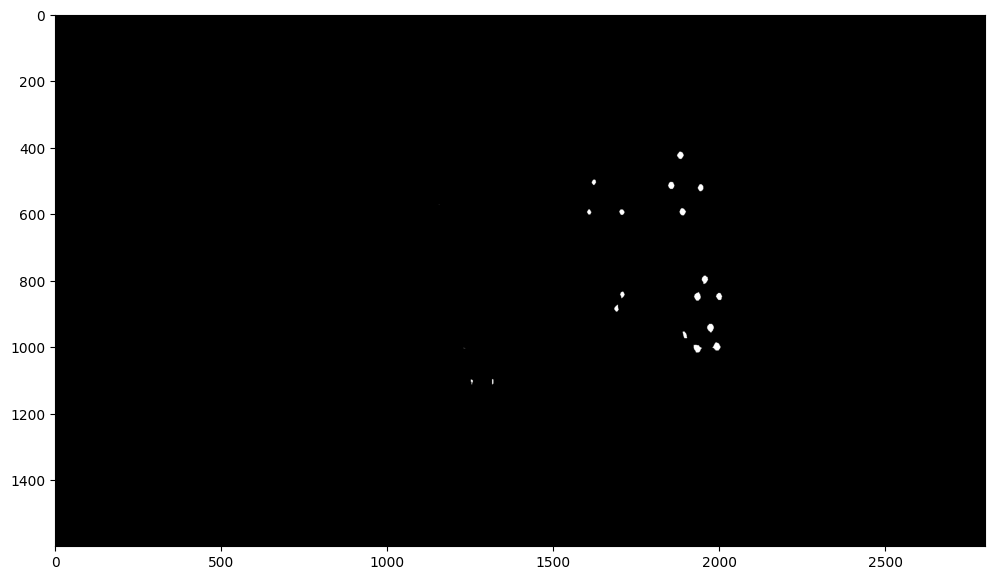

In [370]:
no_large_objects = remove_large_objects(pills > 0, 1000)
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(no_large_objects, cmap="gray")

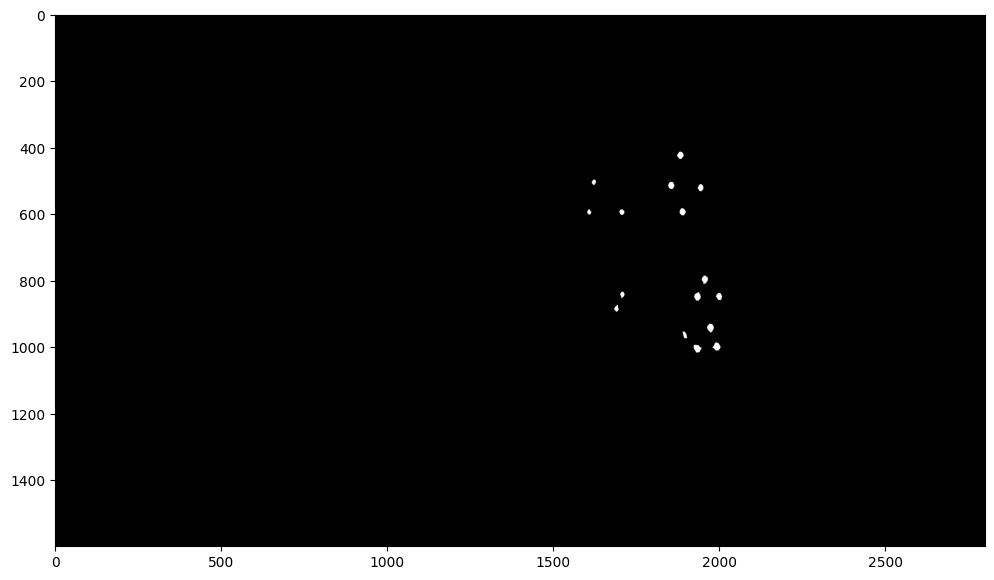

In [371]:
no_small_objects = remove_small_objects(no_large_objects, min_size=70)
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(no_small_objects, cmap="gray")

In [372]:
thresholded_img_whites = None


@interact(
    img=fixed(calib_eq_hist),
    r=IntRangeSlider(
        min=0, max=255, step=1, value=[175, 255], layout=Layout(width="500px")
    ),
    g=IntRangeSlider(
        min=0, max=255, step=1, value=[175, 255], layout=Layout(width="500px")
    ),
    b=IntRangeSlider(
        min=0, max=255, step=1, value=[175, 255], layout=Layout(width="500px")
    ),
)
def get_in_range(img, r, g, b):
    global thresholded_img_whites
    min_r, max_r = r
    min_g, max_g = g
    min_b, max_b = b

    thresholded = cv2.inRange(img, (min_r, min_g, min_b), (max_r, max_g, max_b))

    plt.subplots(1, 1, figsize=(12, 8))[1].imshow(thresholded, cmap="gray")
    thresholded_img_whites = thresholded

interactive(children=(IntRangeSlider(value=(175, 255), description='r', layout=Layout(width='500px'), max=255)…

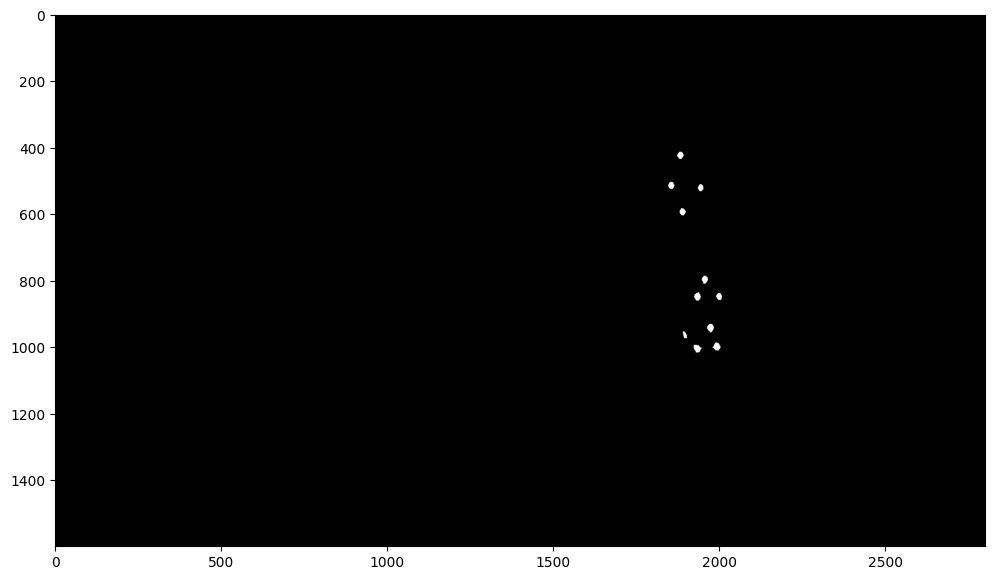

In [373]:
markers = no_small_objects & thresholded_img_whites
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(markers, cmap="gray")

In [374]:
np.unique(thresholded_img_pillbox)

array([  0, 255], dtype=uint8)

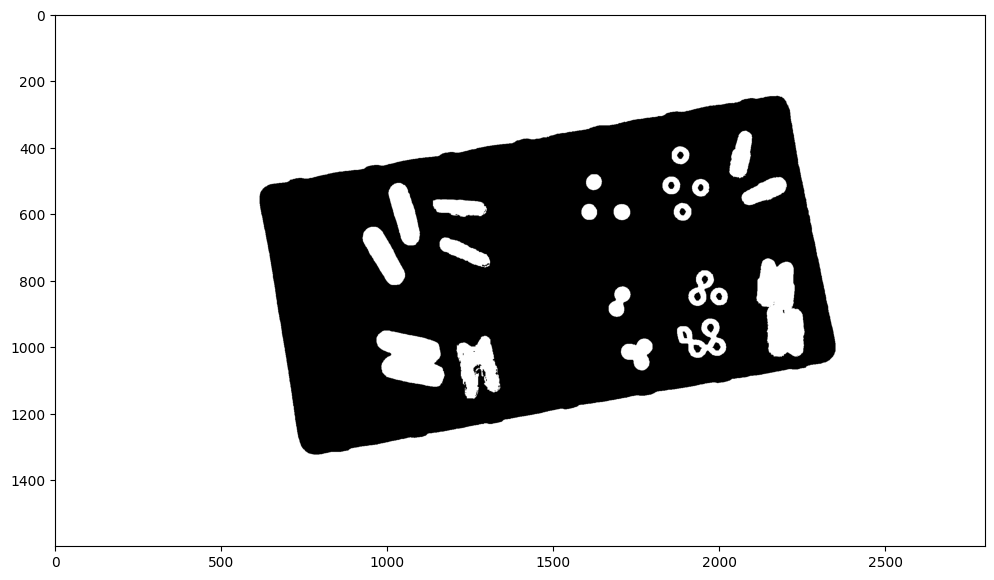

In [375]:
unknown = cv2.subtract(
    thresholded_img_pillbox.astype(np.bool_).astype(np.uint8), markers
)
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(unknown, cmap="gray")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


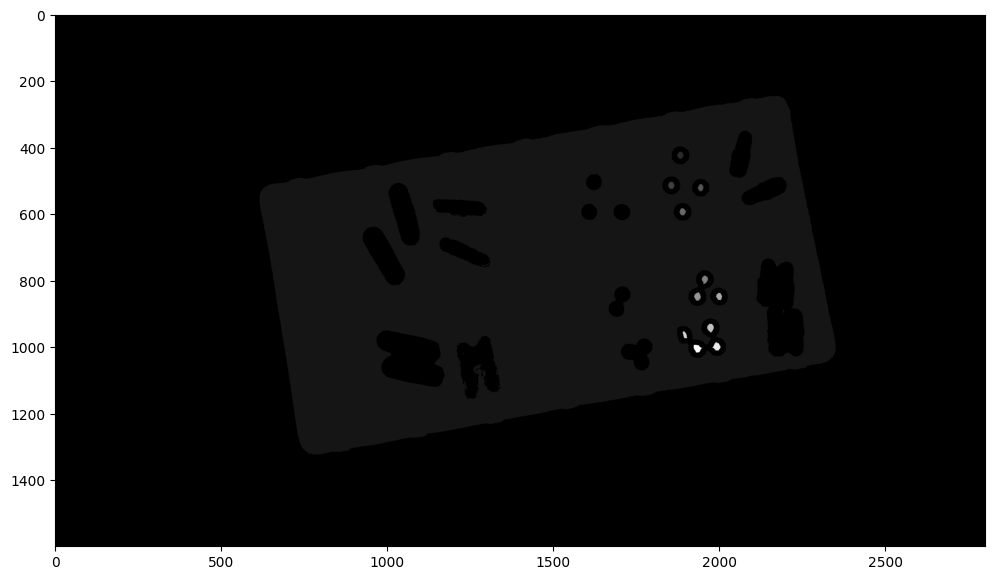

In [376]:
ret, components = cv2.connectedComponents(markers)
components = components + 1

components[unknown == 1] = 0
print(np.unique(components))
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(components, cmap="gray")

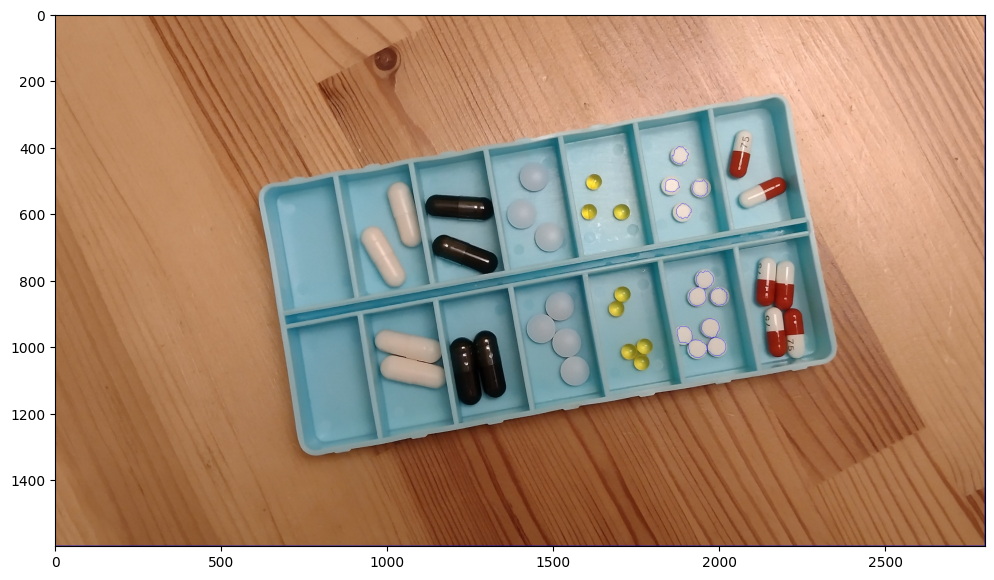

In [377]:
results = cv2.watershed(calib_eq_hist, components)
result_img = calib_eq_hist.copy()
result_img[results == -1] = [0, 0, 255]
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(result_img, cmap="gray")

In [379]:
np.unique(results)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

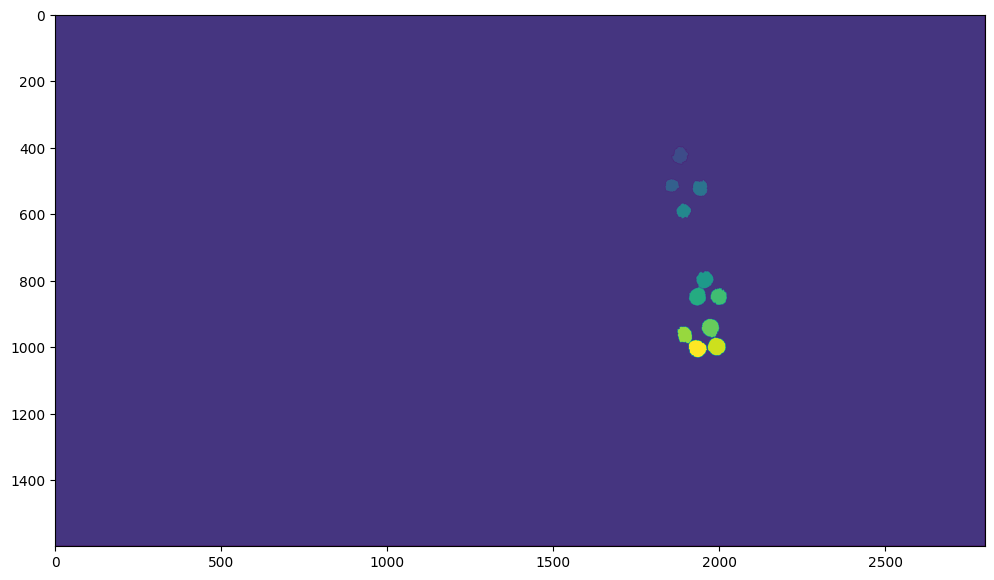

In [387]:
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(results)